In [3]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, SimpleRNN, LSTM, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import visualkeras
from utils.utils import *

In [4]:
train_idxs = read_indexes('./utils/train.txt')
validation_idxs =  read_indexes('./utils/validation.txt')
test_idxs = read_indexes('./utils/test.txt')

In [5]:
data_indexes = [(i+1,j+1) for i in range(5) for j in range(2000)]
parameters = load_parameter_list()
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes

y_train = df_parameters[df_parameters['data_index'].isin(train_idxs)].drop('data_index', axis = 1)
y_validation = df_parameters[df_parameters['data_index'].isin(validation_idxs)].drop('data_index', axis = 1)
y_test = df_parameters[df_parameters['data_index'].isin(test_idxs)].drop('data_index', axis = 1)

In [20]:
y_train

,cx,cy,a,b,theta,e1,e2
0,-0.707487,4.217239,2.152750,0.745700,0.527199,3.553770,2.882795
3,-0.033557,1.497364,1.681813,0.767738,0.193667,2.030458,0.409182
7,0.807062,3.635175,1.364334,0.584842,-0.097724,1.775325,3.669727
8,-1.006160,3.055372,0.889733,0.595210,0.117413,2.986844,6.359471
9,-1.065056,3.415461,2.134161,0.469542,0.213083,0.631662,4.245931
...,...,...,...,...,...,...,...
9985,1.086057,2.658060,1.366633,0.270978,0.171611,1.200613,1.177018
9987,0.757753,4.860306,1.038583,0.910046,0.242614,3.687656,0.704631
9993,1.551056,2.814092,1.759765,1.496809,-0.301669,1.687119,5.385693
9996,-2.163828,5.903978,2.049204,0.388988,0.380152,1.848904,3.822509


In [23]:
X_train = np.array(load_data(train_idxs, small = True))
print('train loaded')
X_validation = np.array(load_data(validation_idxs, small = True))
print('validation loaded')
X_test = np.array(load_data(test_idxs, small = True))
print('test loaded')

train loaded
validation loaded
test loaded


In [15]:
mean = np.mean(X_train.flatten())
std = np.std(X_train.flatten())

In [16]:
mean, std

(0.0028952856924112018, 0.01585630079850641)

In [17]:
X_train_norm = (X_train-mean)/std
X_validation_norm = (X_validation-mean)/std
X_test_norm = (X_test-mean)/std

# Feedforward model

In [40]:
# Feedforward model
feedforward = tf.keras.Sequential([
    Input(shape=(440, 17)),
    Flatten(),  
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'), 
    Dense(7)                         
])

feedforward.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
feedforward.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 7480)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              7660544   
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 7)                

In [41]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = feedforward.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, verbose = 1, callbacks=[early_stopping])

Epoch 1/40
133/133 [==============================] - 11s 77ms/step - loss: 1.5758 - mae: 0.8517 - mse: 1.5758 - val_loss: 1.2417 - val_mae: 0.7397 - val_mse: 1.2417
Epoch 2/40
133/133 [==============================] - 9s 71ms/step - loss: 1.1275 - mae: 0.7034 - mse: 1.1275 - val_loss: 1.0557 - val_mae: 0.6572 - val_mse: 1.0557
Epoch 3/40
133/133 [==============================] - 10s 72ms/step - loss: 1.0300 - mae: 0.6534 - mse: 1.0300 - val_loss: 1.1063 - val_mae: 0.6451 - val_mse: 1.1063
Epoch 4/40
133/133 [==============================] - 9s 71ms/step - loss: 0.9558 - mae: 0.6200 - mse: 0.9558 - val_loss: 0.9226 - val_mae: 0.5950 - val_mse: 0.9226
Epoch 5/40
133/133 [==============================] - 10s 72ms/step - loss: 0.8650 - mae: 0.5847 - mse: 0.8650 - val_loss: 0.9736 - val_mae: 0.6152 - val_mse: 0.9736
Epoch 6/40
133/133 [==============================] - 10s 72ms/step - loss: 0.8797 - mae: 0.5911 - mse: 0.8797 - val_loss: 0.8558 - val_mae: 0.5498 - val_mse: 0.8558
Epoch 

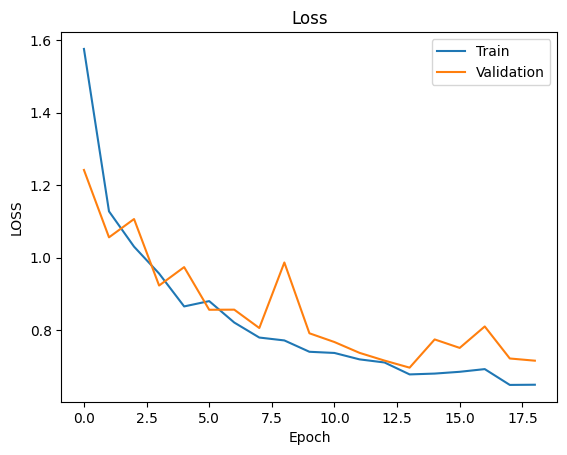

In [43]:
plot_metrics(history, 'loss')

In [44]:
model_evaluation(feedforward, X_test, y_test)

45/45 [==============================] - 0s 4ms/step - loss: 0.6624 - mae: 0.4776 - mse: 0.6624
Test mae: 0.4775702655315399
Test mse: 0.6623666882514954
1/1 [==============================] - 0s 82ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 3.027	4.346	1.127	0.023	0.439	0.547	4.861
prediction:	 1.010	3.915	0.902	0.120	0.204	1.622	3.693
------------
real:		 1.602	3.656	1.499	1.258	0.247	0.094	2.505
prediction:	 1.577	3.637	1.575	1.018	0.096	-0.013	2.462
------------
real:		 -0.122	2.202	0.987	0.386	-0.128	4.719	7.439
prediction:	 -0.194	2.275	1.162	0.333	0.135	4.380	4.434
------------
real:		 0.084	2.420	1.237	0.047	-0.064	4.162	3.578
prediction:	 0.377	2.452	1.029	0.199	0.126	3.099	2.951
------------
real:		 1.553	2.920	0.866	0.105	0.273	0.830	3.094
prediction:	 1.298	3.507	0.954	0.163	0.190	1.368	4.224


# Convolutional model

In [45]:
cnn = tf.keras.Sequential([
# First Convolutional Block with padding
  Conv2D(32, (3, 3), activation='relu', input_shape=(440, 17, 1), padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),

  # Second Convolutional Block with increased filters and padding
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),

  # Third Convolutional Block with increased filters, kernel size and padding
  Conv2D(128, (5, 5), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),


  # Flatten layer
  Flatten(),

  # Dense layers with Dropout for better regularization
  Dense(1024, activation='relu'),
  Dense(256, activation='relu'),
  Dense(64, activation='relu'), 
  # Final output layer with 7 neurons
  Dense(7)
])

cnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 440, 17, 32)       320       
                                                                 
 batch_normalization_3 (Bat  (None, 440, 17, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 220, 8, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 8, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 220, 8, 64)        256       
 chNormalization)                                                
                                                      

In [47]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, verbose = 1, callbacks=[early_stopping])

Epoch 1/40
133/133 [==============================] - 33s 235ms/step - loss: 8.1999 - mae: 1.1220 - mse: 8.1999 - val_loss: 5.3616 - val_mae: 1.7069 - val_mse: 5.3616
Epoch 2/40
133/133 [==============================] - 31s 230ms/step - loss: 1.0234 - mae: 0.6892 - mse: 1.0234 - val_loss: 4.9324 - val_mae: 1.6756 - val_mse: 4.9324
Epoch 3/40
133/133 [==============================] - 31s 231ms/step - loss: 0.8940 - mae: 0.6226 - mse: 0.8940 - val_loss: 3.4215 - val_mae: 1.3026 - val_mse: 3.4215
Epoch 4/40
133/133 [==============================] - 31s 230ms/step - loss: 0.8412 - mae: 0.5851 - mse: 0.8412 - val_loss: 3.6788 - val_mae: 1.3852 - val_mse: 3.6788
Epoch 5/40
133/133 [==============================] - 31s 232ms/step - loss: 0.7785 - mae: 0.5535 - mse: 0.7785 - val_loss: 2.7687 - val_mae: 1.0985 - val_mse: 2.7687
Epoch 6/40
133/133 [==============================] - 31s 232ms/step - loss: 0.7240 - mae: 0.5390 - mse: 0.7240 - val_loss: 1.1709 - val_mae: 0.7927 - val_mse: 1.170

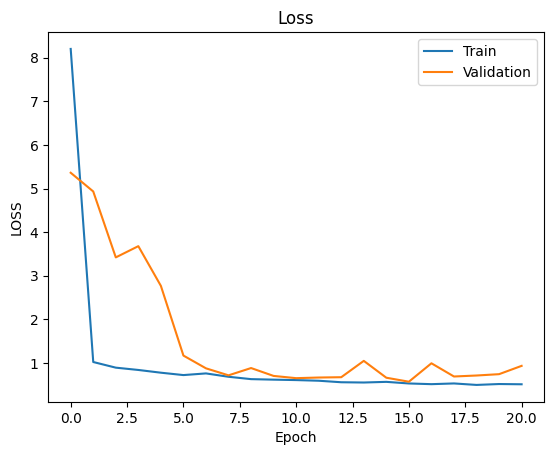

In [48]:
plot_metrics(history, 'loss')

In [49]:
model_evaluation(cnn, X_test, y_test,)

45/45 [==============================] - 2s 43ms/step - loss: 0.5614 - mae: 0.4556 - mse: 0.5614
Test mae: 0.4555557370185852
Test mse: 0.5613623857498169
1/1 [==============================] - 0s 129ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.666	4.713	1.343	1.126	0.475	1.336	6.544
prediction:	 2.091	5.161	1.555	1.050	0.140	1.206	6.333
------------
real:		 0.438	5.417	0.643	0.265	0.181	3.047	7.502
prediction:	 0.204	5.217	0.963	0.323	0.199	3.239	3.482
------------
real:		 0.644	3.594	2.021	0.654	0.450	4.522	3.774
prediction:	 1.058	3.793	2.109	0.922	0.403	3.430	3.813
------------
real:		 -0.114	4.270	0.995	0.403	0.237	1.449	5.253
prediction:	 0.129	4.607	1.204	0.235	0.126	1.591	5.528
------------
real:		 0.394	2.981	1.678	0.811	-0.408	1.934	7.187
prediction:	 0.637	2.891	1.704	0.968	-0.371	1.347	5.071


# Recurrent Neural Network with simple RNN layer

In [50]:
rnn = tf.keras.Sequential([
    SimpleRNN(512, input_shape=(440, 17), return_sequences=True),
    SimpleRNN(256),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 440, 512)          271360    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               196864    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 7)                 455       
                                                                 
Total params: 509831 (1.94 MB)
Trainable params: 509831 (1.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, verbose = 1, callbacks=[early_stopping])

Epoch 1/40
133/133 [==============================] - 58s 423ms/step - loss: 1.6833 - mae: 0.8991 - mse: 1.6833 - val_loss: 1.4679 - val_mae: 0.8309 - val_mse: 1.4679
Epoch 2/40
133/133 [==============================] - 55s 414ms/step - loss: 1.4663 - mae: 0.8422 - mse: 1.4663 - val_loss: 1.4559 - val_mae: 0.8288 - val_mse: 1.4559
Epoch 3/40
133/133 [==============================] - 55s 416ms/step - loss: 1.4670 - mae: 0.8413 - mse: 1.4670 - val_loss: 1.4979 - val_mae: 0.8411 - val_mse: 1.4979
Epoch 4/40
133/133 [==============================] - 56s 418ms/step - loss: 1.4661 - mae: 0.8412 - mse: 1.4661 - val_loss: 1.4837 - val_mae: 0.8366 - val_mse: 1.4837
Epoch 5/40
133/133 [==============================] - 57s 425ms/step - loss: 1.4605 - mae: 0.8384 - mse: 1.4605 - val_loss: 1.4908 - val_mae: 0.8434 - val_mse: 1.4908
Epoch 6/40
133/133 [==============================] - 55s 418ms/step - loss: 1.4519 - mae: 0.8368 - mse: 1.4519 - val_loss: 1.4520 - val_mae: 0.8292 - val_mse: 1.452

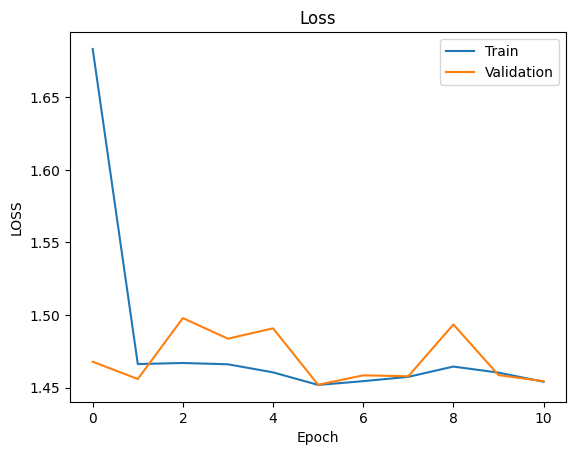

In [52]:
plot_metrics(history, 'loss')

In [53]:
model_evaluation(rnn, X_test, y_test)

45/45 [==============================] - 7s 154ms/step - loss: 1.4301 - mae: 0.8244 - mse: 1.4301
Test mae: 0.82444167137146
Test mse: 1.4300614595413208
1/1 [==============================] - 0s 320ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.532	3.774	2.034	0.272	0.266	2.737	3.284
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 1.392	4.172	1.497	0.793	0.679	0.430	4.179
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 0.949	2.186	1.636	0.650	0.552	0.101	4.052
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 0.440	4.961	1.237	0.775	-0.585	1.431	0.658
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166
------------
real:		 -0.318	2.314	0.592	0.324	0.403	1.349	7.563
prediction:	 0.277	3.538	1.300	0.517	0.183	2.640	4.166


#  Recurrent Neural Network Model with LSTM

In [54]:
rnn_lstm = tf.keras.Sequential([
    LSTM(512, input_shape=(440, 17)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
rnn_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1085440   
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 7)                 455       
                                                                 
Total params: 1258375 (4.80 MB)
Trainable params: 1258375 (4.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn_lstm.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, verbose = 1, callbacks=[early_stopping])

Epoch 1/20
133/133 [==============================] - 149s 1s/step - loss: 1.6882 - mae: 0.8890 - mse: 1.6882 - val_loss: 1.4810 - val_mae: 0.8402 - val_mse: 1.4810
Epoch 2/20
133/133 [==============================] - 146s 1s/step - loss: 1.4838 - mae: 0.8446 - mse: 1.4838 - val_loss: 1.4743 - val_mae: 0.8318 - val_mse: 1.4743
Epoch 3/20
133/133 [==============================] - 146s 1s/step - loss: 1.4585 - mae: 0.8403 - mse: 1.4585 - val_loss: 1.4853 - val_mae: 0.8413 - val_mse: 1.4853
Epoch 4/20
133/133 [==============================] - 142s 1s/step - loss: 1.4559 - mae: 0.8387 - mse: 1.4559 - val_loss: 1.4441 - val_mae: 0.8292 - val_mse: 1.4441
Epoch 5/20
133/133 [==============================] - 141s 1s/step - loss: 1.4088 - mae: 0.8249 - mse: 1.4088 - val_loss: 1.3528 - val_mae: 0.8024 - val_mse: 1.3528
Epoch 6/20
133/133 [==============================] - 140s 1s/step - loss: 1.3442 - mae: 0.8029 - mse: 1.3442 - val_loss: 1.3402 - val_mae: 0.7950 - val_mse: 1.3402
Epoch 7/20

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(rnn_lstm, X_test, y_test,)